# JWST Transmission/Transit Chemically Consistent Tutorial  

Welcome to the JWST transmission spectrum model/retrieval tutorial!

For this particular setup, the atmosphere is parameterized within the "chemically-consistent" framework as described in Kreidberg et al. 2015.  The atmospheric composition is parameterized with only a metalicity and carbon-to-oxygen ratio assumed to be in thermochemical equilibrium along the temperature-pressure profile.  Originally this code would compute the gas and condensate phase mixing ratios by calling the NASA CEA routine. However, in order to remove fortran dependencies, a finely sampled pre-computed, interpolateable chemistry grid was instead produced with CEA as a function of temperature (T from 400K - 3400K in 100K increments), pressure ($log_{10}(P)$ from -7.0 (0.1$\mu$bar) - 2.4 (316 bar) in 0.1 increments), metallicity ($[M/H]$ from -2.0 (0.01$\times$) to 3.0 (1000$\times$)), and C/O ($log_{10}(C/O)$ from -2.0 (0.01) to 0.3 (2) awkwardly spaced to better sample the transition about C/O=1). All elemental abundances are scaled with respect to the Lodders 2009 solar abundance pattern.  A pseudo-hack rainout approximation is made to the gas phase abundances of TiO, VO, Na, K, and FeH.  In this hack, these species are set to 0 abundance at levels above where they first fall below some critical value ($10^{-8}$). This is to mimic the loss of these species from the gas phase into the condensate phase. In no case are we accounting for the loss of elemental abundances.

The 3-parameter temperature profile parameterization utilizes the Guillot 2010/Parmentier et al. 2014 analytic formulism (see Line et al. 2013a for implementation details).     

The transmission spectrum routine closely follows the equations (and figure) in Tinetti et al. 2012 (as described in the tutorial text).  Instead of using line-by-line, or "sampled" cross-sections, this implementation uses the "correlated-K" method (see Lacis & Oinas 1990, or more recently Amundsen et al. 2017). Correlated-K is advantageous as it preserves the wavelength bin"integrated"  precision as line-by-line but with far less demanding computation.  We include as correlated-K line opacites H2O, CH4, CO, CO2, NH3, HCN, H2S, C2H2, Na, K, TiO, VO, FeH and as continuum gas opacities H2-H2, H2-He CIA, and the H- bound free and free free (e.g., Arcangeli et al. 2018).  See the "opacity" tutorial for more details on correlated-K. 

To handle the effects of disequilibrium chemistry due to vertical mixing, we apply the "quench-pressure" approximation.  We include a quench pressure parameter for the carbon-system and one for the nitrogen system (as in Morley et al. 2017 for GJ436b, and Kreidberg et al. 2018 for WASP-107b).  The carbon quench pressure fixes the H2O, CO, and CH4 abundances above the quench pressure level to their abundances at the quench pressure level.  Similarly, the nitrogen quench pressure fixes the N2, NH3, and HCN abundances above the quench pressure to their values at the quench pressure level.  This is indeed a kludge, and a better implementation would be to use the timescale/eddy mixing prescription described in Zahnle & Marley 2015.  Regardless, any non-full kinetics approach is a kludge anyway (not to mention the 1D nature of the problem...).  

There are two different cloud prescriptions built in.  The first is the Ackerman & Marley 2001 "eddy-sed" approach that self-consistently computes the vertical particle size distribution given a sedimentation factor, $f_{sed}$ and an eddy mixing factor (K$_{zz}$) from some cloud base pressure and intrinsic condensate mixing ratio.  The classic "power-law haze" and "grey cloud" prescripton is also included.

Finally, if one doesn't like the "chemically-consistent" concept, they can use the "gas_scale" array to switch off or scale the abundances each opacity source.  

This specific notebook goes through the steps to generate the forward model, and illustrate how to actually perform the retrieval. However, the retrievals are bust run on a compute cluster or a node with more than 4 cores.  We will first creat a fake dataset at an R=100 to emulate what we might expect from JWST.

Note, this particular version does not include marginilzation over spots (e.g., Iyer & Line 2019).  However, this can be trivially implemented in the fx_trans rouutine in fm.py.  Simply add in the "rackham" formula along with a grid of stellar spectral models, say, drawn from pysynphot (or whatever your favorite stellar model generator is).  Interpolate over this grid of stellar models using standard built in python linear interpolators.


Software Requirements: This runs in the python 3 anaconda environment.  It is also crucial that anaconda numba is installed as many of the routines are optimized using numba's "@jit" decorator (http://numba.pydata.org/). 


# Import Routines

This first segment loads in the routines from fm.py and the correlated-K coefficients.  The JWST xsecs (really, correlated-K) are at an R=100 < 20 microns (> 500 cm-1) and R=50 > 20 microns (<500 cm-1).
Note that the "core" set of routines are all in fm.py.  The thermal emission radiative transfer solver is toonpy.py and the incident stellar flux solver is toonpy_solar.py  If you want to know more about what is in the sausage, look into these routines.  Note...these *are not sampled cross-sections* so each resolution element at that R is correctly computed and matches line-by-line when binned to that same R.

Note that the "core" set of routines are all in fm.py.  If you want to know more about what is in the sausage, look into fm.py.  

In [2]:
#import all of the functions in fm, namely, the CK-coefficients (may take a minute)
from chimera import *
%matplotlib notebook


# Make Stellar 

In [ ]:
stellar_file = 'sum_star.h5'
temp = 5000
logmh = 0 
logg = 4.0
stellar_db = 'phoenix'
make_stellar(temp,logmh,logg,stellar_db,stellar_file)

# Load Opacities

In [ ]:
#preload CK-coeffs--a giant array/variable to be passed--inputs are lower wavenumber, upper wavenumber
#between 50 and 30000 cm-1 with R = 100 > 500 cm-1 (<20 um) and R=50 <500 cm-1 (>20 um)
#to convert between microns and wavenumbers-- wavelength [um] = 10,000/wavenumber [cm-1]
#make sure xsec wavenumber/wavelength range is *larger* than data wavelength range
wnomin = 750
wnomax = 15000
observatory='JWST'
directory = os.path.join(os.getcwd(),'..','..','ABSCOEFF_CK')
xsecs=xsects(wnomin, wnomax, observatory, directory,stellar_file=stellar_file)


# Setup Atmospheric Parameters to Generate a Spectrum 

This segement defines the various atmospheric quantities and assignes them values for the generation of a simple transmission spectrum.  A description of each parameter along with a reasonable range of values is given as a comment following the assigned value. All of the parameters are then put into the parameter "state-vector" array, x.

In [3]:
#setup "input" parameters. We are defining our 1D atmosphere with these
#the parameters
#planet/star system params--xRp is the "Rp" free parameter, M right now is fixed, but could be free param
Rp=1.036  #Planet radius in Jupiter Radii--this will be forced to be 10 bar radius--arbitrary (scaling to this is free par)
Rstar=0.667 # #Stellar Radius in Solar Radii
M =2.034  #Mass in Jupiter Masses
D=0.01526   #semimajor axis in AU

#TP profile params (3--Guillot 2010, Parmentier & Guillot 2013--see Line et al. 2013a for implementation)
Tirr=1400     #Irradiation temperature as defined in Guillot 2010
logKir=-1.5  #TP profile IR opacity (log there-of) controlls the "vertical" location of the gradient
logg1=-0.7     #single channel Vis/IR (log) opacity. Controls the delta T between deep T and TOA T
Tint=200 #interior temperature...this would be the "effective temperature" if object were not irradiated

#Composition parameters---assumes "chemically consistent model" described in Kreidberg et al. 2015
logMet=0.0  #.   #Metallicity relative to solar log--solar is 0, 10x=1, 0.1x = -1: valid range is -1.5 - 3.0
logCtoO=-0.26   #log C-to-O ratio: log solar is -0.26: valid range is -1.0 - 0.3 
logPQCarbon=-5.5  #CH4, CO, H2O Qunech pressure--forces CH4, CO, and H2O to constant value at quench pressure value: valid range -6.0 - 1.5
logPQNitrogen=-5.5  #N2, NH3 Quench pressure--forces N2 and NH3 to ""  

#Ackerman & Marley 2001 Cloud parameters--physically motivated with Mie particles
logKzz=7 #log Kzz (cm2/s)--valid range: 2 - 11 -- higher values make larger particles
fsed=2.0 #sediminetation efficiency--valid range: 0.5 - 5--lower values make "puffier" more extended cloud 
logPbase=-1.0  #cloud base pressure--valid range: -6.0 - 1.5
logCldVMR=-5.5 #cloud condensate base mixing ratio (e.g, see Fortney 2005)--valid range: -15 - -2.0

#simple 'grey+rayleigh' parameters just in case you don't want to use a physically motivated cloud
#(most are just made up anyway since we don't really understand all of the micro-physics.....)
logKcld = -40  #uniform in altitude and in wavelength "grey" opacity (it's a cross-section)--valid range: -50 - -10 
logRayAmp = -30  #power-law haze amplitude (log) as defined in des Etangs 2008 "0" would be like H2/He scat--valid range: -30 - 3 
RaySlope = 0  #power law index 4 for Rayleigh, 0 for "gray".  Valid range: 0 - 6

#10 bar radiuss scaling param (only used in transmission)
xRp=0.991

#stuffing all variables into state vector array
x=np.array([Tirr, logKir,logg1,Tint, logMet, logCtoO, logPQCarbon,logPQNitrogen, Rp*xRp, Rstar, M, logKzz, fsed,logPbase,logCldVMR, logKcld, logRayAmp, RaySlope])
#gas scaling factors to mess with turning on various species
#set to "0" to turn off a gas. Otherwise keep set at 1
#thermochemical gas profile scaling factors
# 0   1    2    3   4    5    6     7    8    9   10    11   12   13    14   15   16   17   18  19 20   21
#H2O  CH4  CO  CO2 NH3  N2   HCN   H2S  PH3  C2H2 C2H6  Na    K   TiO   VO   FeH  H    H2   He   e- h-  mmw
gas_scale=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1., 1., 1.]) #can be made free params if desired (won't affect mmw)#can be made free params if desired (won't affect mmw)

# Generate Model Atmosphere & Transmission Spectrum -------------------------  

Here we call the forward model routine "fx" (think F(x)) from fm.py.  fx controls the input values and calls the relevent functions to compute the transmission spectrum.  The inputs into fx are the parameter state vector, "x", the  data wavelength grid, "wlgrid", the gas scaling factors (for turning off particular gases), "gas_scale", and the correlated-K tables, "xsects".  Fx then returns the simulated model spectrum ($(R_p/R_{\star})^2$) at the native CK-table resolution, "y_mod", the native wavenumber grid, "wno", the data wavelength grid binned model spectrum, "y_binned".  The "atm" array contains the generated temperature-pressure profile and gas mixing ratio profiles generated under the chemically consistent assumption. 

In [4]:
#calling forward model, fx. This will produce the (Rp/Rstar)^2 spectrum....
wlgrid=-1 #this is just a flag to let the wl binning routine to know that we are creating fake data
y_binned,y_mod,wno,atm=fx_trans(x,wlgrid,gas_scale, xsecs)  #returns binned model spectrum, higher res model spectrum, wavenumber grid, and vertical abundance profiles from chemistry

print('DONE')

DONE


# Generate Simulated Data


In [5]:
err_ppm=30. #error bar in ppm (just constant here)
err=np.ones(len(wno))*err_ppm*1E-6   #this would be a good spot to put pandexo generated error bars
                                     #though they would have to be binned/interpolated to the model wavenumber grid
y_meas = np.random.normal(y_mod, err) #adding gaussian noise
np.savetxt('simulated_trans_JWST.txt',np.array([1E4/wno, y_meas, err]).T) #saveing as txt file (wl [um], Depth, err)


# Plotting the Model Atmosphere & Transmission Spectrum 

Self-explanatory...

# Plot Model Atmosphere  

Spaghetti plot of the model atmosphere.

<IPython.core.display.Javascript object>


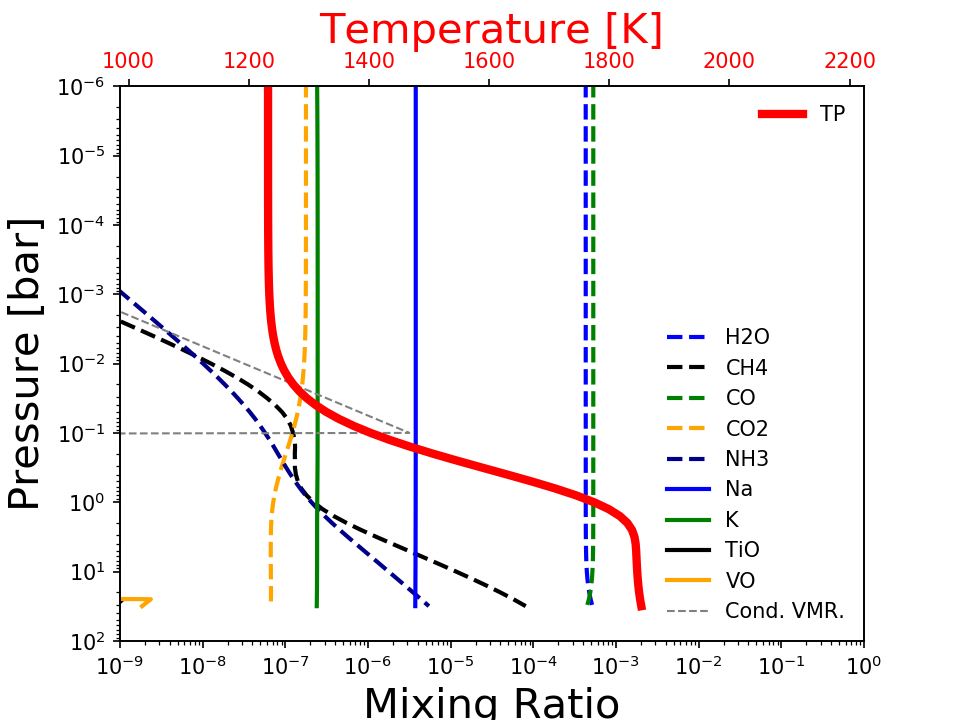

In [6]:
from matplotlib.pyplot import *
from matplotlib.ticker import FormatStrFormatter
%matplotlib notebook

#unpacking variables
#P is in bars
#T is in K
#H2O, CH4,CO,CO2,NH3,Na,K,TiO,VO,C2H2,HCN,H2S,FeH,H2,He are gas mixing ratio profiles
#qc is the condensate abundance profile given an "f_sed" value and cloud base pressure
#r_eff is the effective cloud droplet radius given (see A&M 2001 or Charnay et al. 2017)
#f_r is the mixing ratio array for each of the cloud droplet sizes.
P,T, H2O, CH4,CO,CO2,NH3,Na,K,TiO,VO,C2H2,HCN,H2S,FeH,H2,He,H,e, Hm,qc,r_eff,f_r=atm


fig2, ax1=subplots()
#feel free to plot whatever you want here....
ax1.semilogx(H2O,P,'b',ls='--',lw=2,label='H2O')
ax1.semilogx(CH4,P,'black',ls='--',lw=2,label='CH4')
ax1.semilogx(CO,P,'g',ls='--',lw=2,label='CO')
ax1.semilogx(CO2,P,'orange',ls='--',lw=2,label='CO2')
ax1.semilogx(NH3,P,'darkblue',ls='--',lw=2,label='NH3')
ax1.semilogx(Na,P,'b',lw=2,label='Na')
ax1.semilogx(K,P,'g',lw=2,label='K')
ax1.semilogx(TiO,P,'k',lw=2,label='TiO')
ax1.semilogx(VO,P,'orange',lw=2,label='VO')
ax1.semilogx(qc,P,'gray',lw=1,ls='--',label='Cond. VMR.')  #<---- A&M Cloud Condensate VMR profile (not droplets)

ax1.set_xlabel('Mixing Ratio',fontsize=20)
ax1.set_ylabel('Pressure [bar]',fontsize=20)
ax1.semilogy()
ax1.legend(loc=4,frameon=False)
ax1.axis([1E-9,1,100,1E-7])

#plotting TP profile on other x-axis
ax2=ax1.twiny()
ax2.semilogy(T,P,'r-',lw='4',label='TP')
ax2.set_xlabel('Temperature [K]',color='r',fontsize=20)
ax2.axis([0.8*T.min(),1.2*T.max(),100,1E-6])
for tl in ax2.get_xticklabels(): tl.set_color('r')
ax2.legend(loc=1,frameon=False)

savefig('./plots/atmosphere_transmission_JWST_CC.pdf',fmt='pdf')
show()
#close()





# Plot Transmission Spectrum Model and Data 


<IPython.core.display.Javascript object>


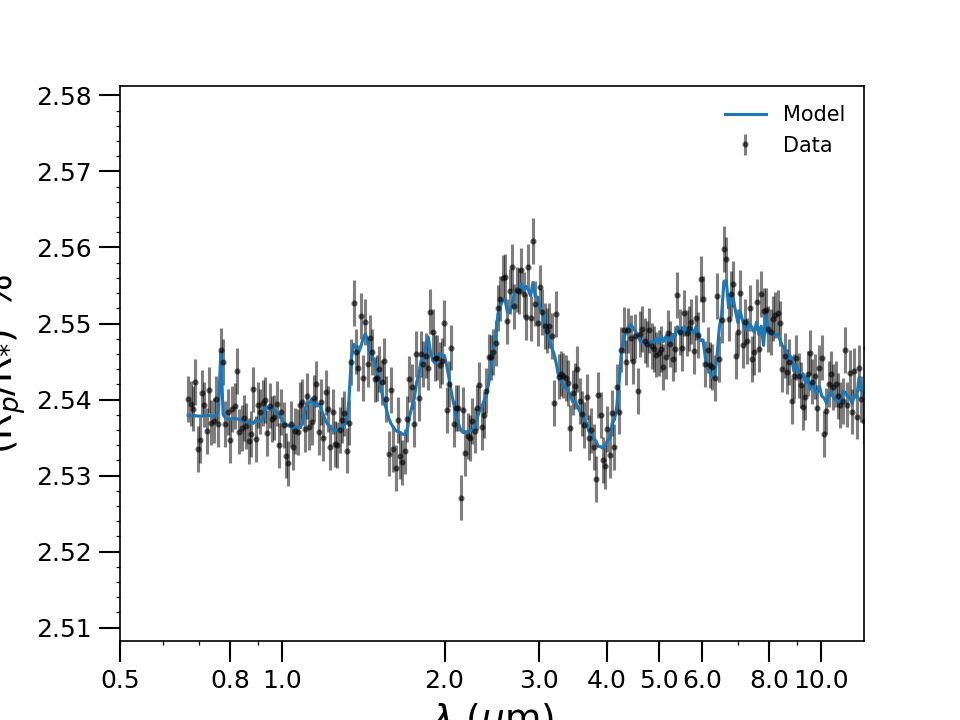

In [7]:
#finally doing some plotting
#and the usual matplotlib shenanigans
ymin=np.min(y_binned)*1E2*0.99
ymax=np.max(y_binned)*1E2*1.01
fig1, ax=subplots()
xlabel('$\lambda$ ($\mu$m)',fontsize=18)
ylabel('(R$_{p}$/R$_{*}$)$^{2} \%$',fontsize=18)
minorticks_on()
errorbar(1E4/wno, y_meas*100, yerr=err*100, xerr=None, fmt='ok',ms=2, label='Data',alpha=0.5)
plot(1E4/wno, y_mod*1E2, label='Model')
ax.set_xscale('log')
ax.set_xticks([0.3, 0.5,0.8,1, 2, 3, 4, 5, 6, 8, 10])
ax.axis([0.5,12,ymin,ymax])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.tick_params(length=10,width=1,labelsize='large',which='major')
legend(frameon=False)
savefig('./plots/transmission_spectrum_JWST_CC.pdf',fmt='pdf')
show()
#close()


# Play around with Transmission Spectrum-------------------------------------

# Explore cloud contribution

DONE
DONE


<IPython.core.display.Javascript object>


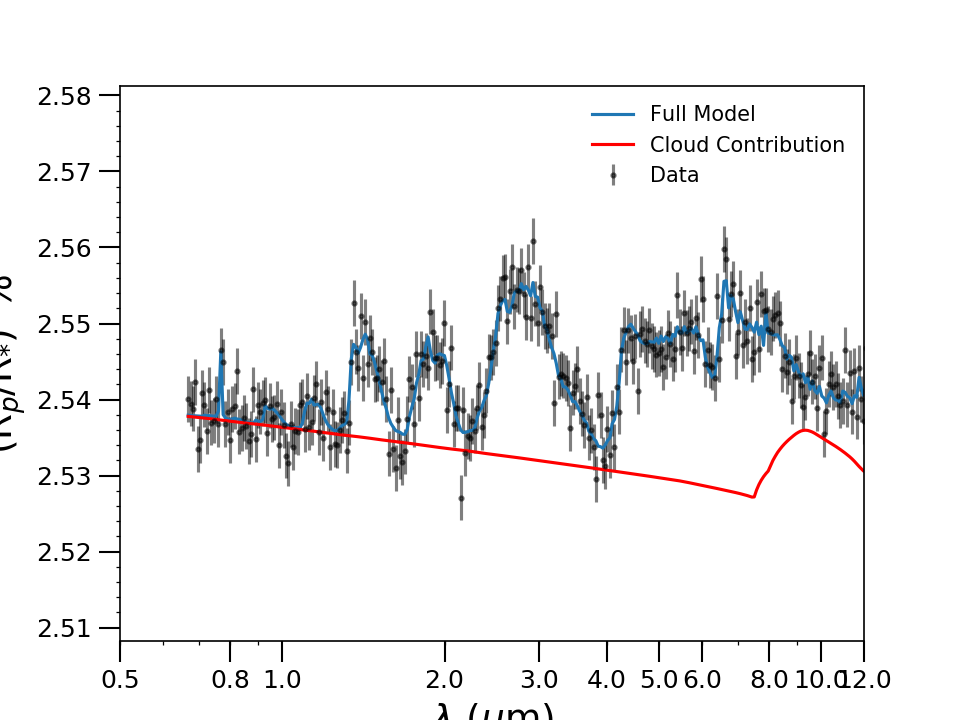

In [8]:
from matplotlib.pyplot import *
from matplotlib.ticker import FormatStrFormatter

###PLAYING WITH CLOUD PARAMETERS HERE
#Ackerman & Marley 2001 Cloud parameters--physically motivated with Mie particles
logKzz=7 #log Kzz (cm2/s)--valid range: 2 - 11 -- higher values make larger particles
fsed=2.0 #sediminetation efficiency--valid range: 0.5 - 5--lower values make "puffier" more extended cloud 
logPbase=-1.0  #cloud base pressure--valid range: -6.0 - 1.5
logCldVMR=-5.5 #cloud condensate base mixing ratio (e.g, see Fortney 2005)--valid range: -15 - -2.0

#simple 'grey+rayleigh' parameters just in case you don't want to use a physically motivated cloud
#(most are just made up anyway since we don't really understand all of the micro-physics.....)
logKcld = -40  #uniform in altitude and in wavelength "grey" opacity (it's a cross-section)--valid range: -50 - -10 
logRayAmp = -10  #power-law haze amplitude (log) as defined in des Etangs 2008 "0" would be like H2/He scat--valid range: -30 - 3 
RaySlope = 0  #power law index 4 for Rayleigh, 0 for "gray".  Valid range: 0 - 6

#10 bar radiuss scaling param (only used in transmission)
xRp=0.991

#stuffing all variables into state vector array
x=np.array([Tirr, logKir,logg1,Tint, logMet, logCtoO, logPQCarbon,logPQNitrogen, Rp*xRp, Rstar, M, logKzz, fsed,logPbase,logCldVMR, logKcld, logRayAmp, RaySlope])
#gas scaling factors to mess with turning on various species


##generating "complete" spectrum (same as above)
# 0   1    2    3   4    5    6     7    8    9   10    11   12   13    14   15   16   17   18  19 20   21
#H2O  CH4  CO  CO2 NH3  N2   HCN   H2S  PH3  C2H2 C2H6  Na    K   TiO   VO   FeH  H    H2   He   e- h-  mmw
gas_scale=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1., 1., 1.]) #can be made free params if desired (won't affect mmw)#can be made free params if desired (won't affect mmw)
#calling forward model, fx. This will produce the (Rp/Rstar)^2 spectrum....
y_binned_0,y_mod_0,wno_0,atm_0=fx_trans(x,wlgrid,gas_scale, xsecs)  #returns binned model spectrum, higher res model spectrum, wavenumber grid, and vertical abundance profiles from chemistry
print('DONE')

##generating cloud component only
gas_scale[:-1]=0. #shutting off all gases!! Whoa! This leaves only the cloud (note, the last index is the m.m.w.)
y_binned_1,y_mod_1,wno_1,atm_1=fx_trans(x,wlgrid,gas_scale, xsecs)  #returns binned model spectrum, higher res model spectrum, wavenumber grid, and vertical abundance profiles from chemistry
print('DONE')


ymin=np.min(y_mod_0)*1E2*0.99
ymax=np.max(y_mod_0)*1E2*1.01
fig1, ax=subplots()
xlabel('$\lambda$ ($\mu$m)',fontsize=18)
ylabel('(R$_{p}$/R$_{*}$)$^{2} \%$',fontsize=18)
minorticks_on()
errorbar(1E4/wno, y_meas*100, yerr=err*100, xerr=None, fmt='ok',ms=2, label='Data',alpha=0.5)
plot(1E4/wno, y_mod_0*1E2, label='Full Model')
plot(1E4/wno, y_mod_1*1E2, label='Cloud Contribution', color='red')

ax.set_xscale('log')
ax.set_xticks([0.3, 0.5,0.8,1, 2, 3, 4, 5, 6, 8, 10, 12])
ax.axis([0.5,12,ymin,ymax])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.tick_params(length=10,width=1,labelsize='large',which='major')
legend(frameon=False)
show()
#close()



# Explore gas contributions

DONE
DONE


<IPython.core.display.Javascript object>


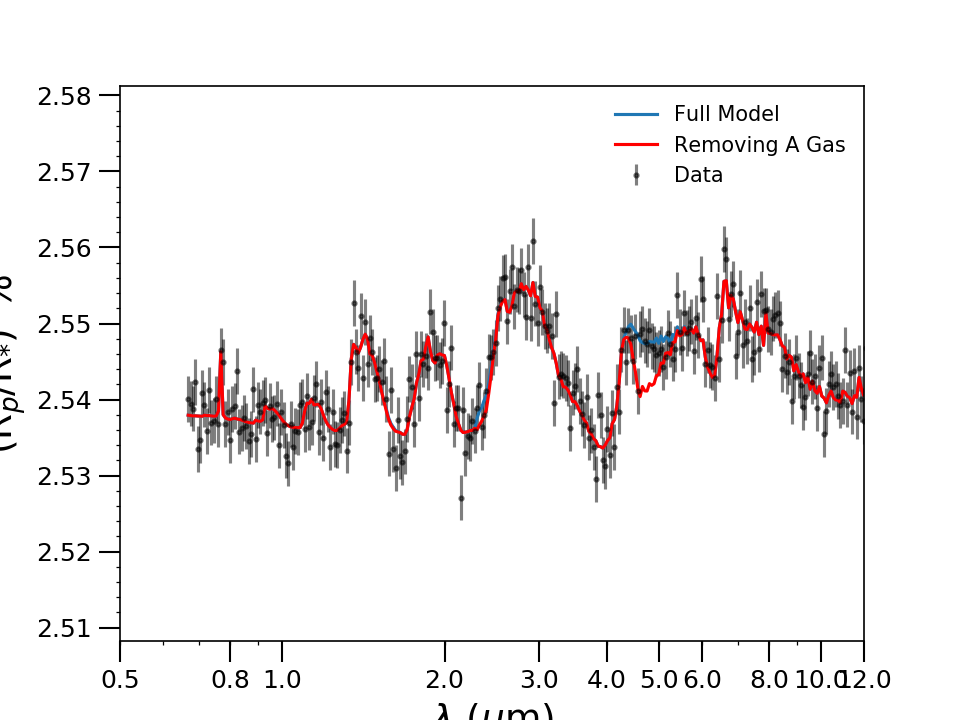

In [10]:
from matplotlib.pyplot import *
from matplotlib.ticker import FormatStrFormatter

#NOTE; Will use whatever "cloud properties" from above

##generating "complete" spectrum (same as above)
# 0   1    2    3   4    5    6     7    8    9   10    11   12   13    14   15   16   17   18  19 20   21
#H2O  CH4  CO  CO2 NH3  N2   HCN   H2S  PH3  C2H2 C2H6  Na    K   TiO   VO   FeH  H    H2   He   e- h-  mmw
gas_scale=np.array([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1., 1., 1.]) #can be made free params if desired (won't affect mmw)#can be made free params if desired (won't affect mmw)
#calling forward model, fx. This will produce the (Rp/Rstar)^2 spectrum....
y_binned_0,y_mod_0,wno_0,atm_0=fx_trans(x,wlgrid,gas_scale, xsecs)  #returns binned model spectrum, higher res model spectrum, wavenumber grid, and vertical abundance profiles from chemistry
print('DONE')

##generating cloud component only
#gas_scale[11]=0. #Na  #shutting off a single gas (use the index map above)
#gas_scale[12]=0. #K  #shutting off a single gas (use the index map above)
gas_scale[2]=0. #CO  #shutting off a single gas (use the index map above)

y_binned_1,y_mod_1,wno_1,atm_1=fx_trans(x,wlgrid,gas_scale, xsecs)  #returns binned model spectrum, higher res model spectrum, wavenumber grid, and vertical abundance profiles from chemistry
print('DONE')

#feel free to remove more gases and add to plotting...

ymin=np.min(y_binned_0)*1E2*0.99
ymax=np.max(y_binned_0)*1E2*1.01
fig1, ax=subplots()
xlabel('$\lambda$ ($\mu$m)',fontsize=18)
ylabel('(R$_{p}$/R$_{*}$)$^{2} \%$',fontsize=18)
minorticks_on()
errorbar(1E4/wno, y_meas*100, yerr=err*100, xerr=None, fmt='ok',ms=2, label='Data',alpha=0.5)
plot(1E4/wno, y_mod_0*1E2, label='Full Model')
plot(1E4/wno, y_mod_1*1E2, label='Removing A Gas', color='red')

ax.set_xscale('log')
ax.set_xticks([0.3, 0.5,0.8,1, 2, 3, 4, 5, 6, 8, 10, 12])
ax.axis([0.5,12,ymin,ymax])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.tick_params(length=10,width=1,labelsize='large',which='major')
legend(frameon=False)
show()
#close()


# Doing Retrieval with PyMultiNest ------------------------------------- 
PyMultiNest (a python wrapper for MultiNest): Buchner et al. 2014 <br>
Paper: https://ui.adsabs.harvard.edu/abs/2014A%26A...564A.125B/abstract)<br>
GitHub: https://johannesbuchner.github.io/PyMultiNest/<br><br>
MultiNest: Feroz & Hobson 2008<br>
Paper: https://ui.adsabs.harvard.edu/abs/2009MNRAS.398.1601F/abstract<br>
GitHub:https://github.com/farhanferoz/MultiNest<br><br>
It is highly advised that you read the relevant sections of these papers and online documentation

# First have to install MultiNest (a bunch of Fortran, C) and PyMultiNest
While dynesty is easy to install and use, it's not quite as an efficient as a sampler as MultiNest/PyMultiNest (at least that I have found).  Here we will re-do the above retrieval, but with the PyMultiNest package. The MultiNest package is readily parallelizeble on any compute cluster or multicore desktop/laptop (using mpi).  Be forewarned, installing PyMultiNest can be a challenge as it is a combination of python, c, and fortran codes. Most compute cluster admins are able to install this package (both within slurm and torque).  Below I outline the steps that I took on my 2016 MacBook Pro with High Sierra (10.13.6) based on a combination of https://www.astrobetter.com/wiki/MultiNest+Installation+Notes and https://exoai.github.io/software/taurex/installation.

Assuming you have some version of MacPorts, execute the following in this order from a terminal command line (note this can take several hours):
1. sudo port install gcc5
2. sudo port select --set gcc mp-gcc5
3. sudo port install cmake
4. sudo port install openblas +gcc5
5. sudo port install openmpi +gcc5
6. sudo port select --set mpi openmpi-mp-fortran
7. git clone https://github.com/JohannesBuchner/MultiNest.git
8. cd MultiNest/build/
9. cmake ..
10. make
11. sudo make install
12. git clone https://github.com/JohannesBuchner/PyMultiNest.git 
13. cd PyMultiNest 
14. python setup.py install





# Time To Run It
OK, time to run. Sorry, you will have to leave the comfort and safety of this notebook, but I'll walk you through it here.  We will be using "mpirun" to run on your multiple processors on your laptop which I have not figured out how to do from a jupyter notebook (maybe you can use spawn or whatever, if your ambitious). 

# STEP 1
 Open the routine "call_pymultinest_transmission_simulated_JWST.py". Have a look, digest it, read the comments, etc.  It should look farily similar to the above dynesty fundtions (e.g., a loglikelihood, prior cube, etc.).  No need to modify anything for this. However, you would modify this script if you wanted to add/remove particular parameters or change the wavelength/wavenumber ranch of the run. 
 
# STEP 2 (really a pseudostep)
Go to the folder (in terminal) where you have downloaded the CHIMERA code (mainly, where "call_pymultinest_transmission.py" lives).  To run using one CPU, simpley type the following:

python call_pymultinest_transmission_simulated_JWST.py.

Wait a minute.  You should see some useless unimportant error messages pop out followed by "Cross-sections Loaded" followed shortely there after by


$*************************$<br>
MultiNest v3.10<br>
Copyright Farhan Feroz & Mike Hobson<br>
Release Jul 2015<br><br>
no. of live points =  500<br> 
dimensionality =    8<br> 
$*************************$ <br>
Starting MultiNest<br>
generating live points



$------------------$

Eventually (a few minutes) you whould see more output:

 live points generated, starting sampling
<br>
Acceptance Rate:                        0.998185<br>
Replacements:                                550<br>
Total Samples:                               551<br>
Nested Sampling ln(Z):            $**************$<br>
Acceptance Rate:                        0.977199<br>
Replacements:                                600<br>
Total Samples:                               614<br>
Nested Sampling ln(Z):            $**************$<br>
Acceptance Rate:                        0.965825<br>
Replacements:                                650<br>
Total Samples:                               673<br>
Nested Sampling ln(Z):            $**************$<br>
Acceptance Rate:                        0.939597<br>
Replacements:                                700<br>
Total Samples:                               745<br>
Nested Sampling ln(Z):            $**************$<br>



Do not be alarmed by the $*****$. It just means that there are too many digits to print out for the inital ln(Z) values.  Eventually normalish looking numbers (usually negative) print out here.  Ok, feel free to kill this now, because we will use mpi to make it faster.

# STEP 3
To do mpi, if everything installed correctly, you just need to type the following into the same command line: <br><br>
mpirun -np 4 python call_pymultinest_transmission_simulated_JWST.py<br><br>
Note, you can use more than 4 cpu's/cores if your computer has them. Use as many as you have. Now, just wait. You should see similar output as for the single cpu, ubt at a faster rate.  For the default setup, with 4 cpu's, this takes $\sim$1hr 10 min (15452 calls). When it is done it will print out this:<br>

 ln(ev)=  -25.249086782326863      +/-  0.12562433089471531    
 Total Likelihood Evaluations:        15452<br>
 Sampling finished. Exiting MultiNest<br>
  analysing data from ./pmn$_$transmission$_$JWST/template_.txt<br>
  analysing data from ./pmn$_$transmission$_$JWST/template_.txt<br>
  analysing data from ./pmn$_$transmission$_$JWST/template_.txt<br>
  analysing data from ./pmn$_$transmission$_$JWST/template_.txt<br>




# STEP 4
When this is done, it is time to plot. Open the routine, "plot_PMN_transmission_simulated_JWST.py".  This will make the usual obnoxious corner plots, a reconstructed "TP" profile (which is kind of meaningless), and will generate sample spectra from random parameter vectors drawn from the posterior.  This last part takes some time.  When this is complete a nice 1-,2-sigma spectral spread plot will pop up.  Feel free to manipulate this to make plots to your liking.  Note, the spectral draws will be saved as a python pickle so that you can twiddle with plot adjustments without haveing to regenerate that each time.  

That's it! You are done!  So after having worked throught his notebook you should feel comfortable playing around with the forward model to gain an understanding of how each parameter influences the spectrum, comfortable running both the dynesty and pymultinest samplers, and plotting up standard output/results.  Good luck.  Note, there is no warrenty, if you get an unpysical answer, that's on you =)

Feel free to move onto the emission tutorial!





